# Model 1: Fully Connected Neural Network 

This notebook builds a simple FCNN baseline for emotion classification. It compares two feature types (Bag-of-Words and TF-IDF) using the same preprocessing and training setup, then reports metrics and learning curves.

Goals:
- Keep preprocessing consistent
- Train FCNN baselines
- Compare BoW vs TF-IDF
- Save results for later comparison

## 1. Load preprocessed data

In [18]:
from pathlib import Path
import re

import pandas as pd

DATA_DIR = Path("../data")

train_df = pd.read_csv(DATA_DIR / "train.txt", sep=";", header=None, names=["text", "emotion"])
test_df = pd.read_csv(DATA_DIR / "test.txt", sep=";", header=None, names=["text", "emotion"])

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

train_df.head()

Train shape: (16000, 2)
Test shape: (2000, 2)


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## 2. Bag-of-Words features (tokenization + one-hot)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


def clean_text(text: str) -> str:
    text = text.lower().strip()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text


train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

vectorizer = CountVectorizer(min_df=2, max_df=0.95)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["emotion"])
y_test = label_encoder.transform(test_df["emotion"])
class_names = list(label_encoder.classes_)

X_train_dense = X_train.toarray().astype("float32")
X_test_dense = X_test.toarray().astype("float32")
num_classes = len(class_names)

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"BoW train shape: {X_train.shape}")
print(f"Dense train shape: {X_train_dense.shape}")
print(f"Classes: {class_names}")

BoW train shape: (16000, 7259)
Dense train shape: (16000, 7259)
Classes: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


## 3. Model definition

In [38]:
import tensorflow as tf

regularizer = tf.keras.regularizers.l2(1e-4)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_dense.shape[1],)),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       929,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 937,926 (3.58 MB)

 Trainable params: 937,926 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

history = model.fit(
    X_train_dense,
    y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5962 - loss: 1.1434 - val_accuracy: 0.8575 - val_loss: 0.5042
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8959 - loss: 0.3904 - val_accuracy: 0.8719 - val_loss: 0.4261
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9425 - loss: 0.2486 - val_accuracy: 0.8788 - val_loss: 0.4219
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9599 - loss: 0.2036 - val_accuracy: 0.8756 - val_loss: 0.4630
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9660 - loss: 0.1866 - val_accuracy: 0.8831 - val_loss: 0.4494


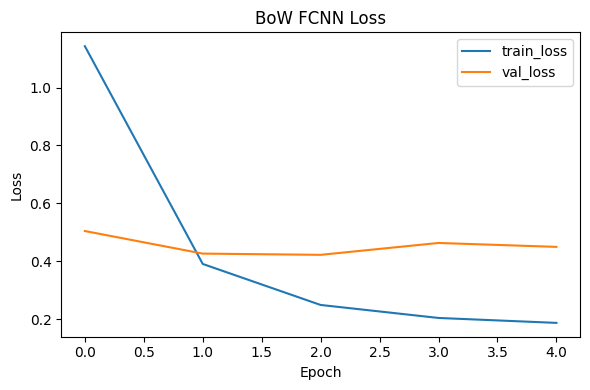

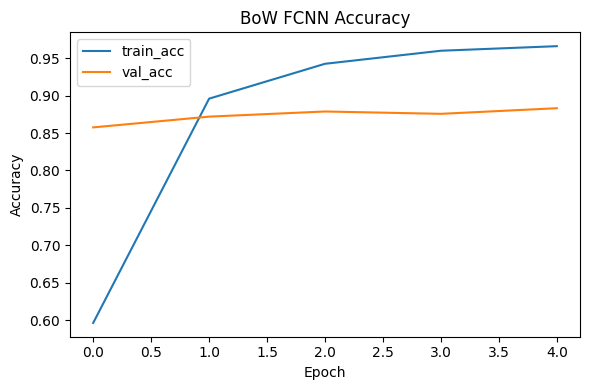

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("BoW FCNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("BoW FCNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

**BoW training curves (interpretation)**
- Training loss drops quickly while validation loss flattens, so the model learns fast and then starts to overfit.
- Validation accuracy stabilizes around the high 0.8s, which suggests the baseline is solid but not improving after a few epochs.
- Early stopping is appropriate to avoid unnecessary epochs once validation stops improving.

## 5. Evaluation on test set

In [41]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

probs = model.predict(X_test_dense)
y_pred = probs.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 (macro): {f1:.4f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.8885
Precision (macro): 0.8431
Recall (macro): 0.8408
F1 (macro): 0.8417

Classification report:

              precision    recall  f1-score   support

       anger       0.90      0.87      0.88       275
        fear       0.82      0.86      0.84       224
         joy       0.91      0.93      0.92       695
        love       0.81      0.76      0.78       159
     sadness       0.93      0.92      0.92       581
    surprise       0.69      0.71      0.70        66

    accuracy                           0.89      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000



## 6. Save metrics

In [42]:
from datetime import datetime

results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)
metrics_path = results_dir / "metrics.csv"

row = {
    "model": "FC_BOW",
    "accuracy": round(accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4),
    "timestamp": datetime.now().isoformat(timespec="seconds"),
}

metrics_df = pd.DataFrame([row])

if metrics_path.exists():
    metrics_df.to_csv(metrics_path, mode="a", header=False, index=False)
else:
    metrics_df.to_csv(metrics_path, index=False)

print(f"Saved metrics to: {metrics_path}")
metrics_df

Saved metrics to: ../results/metrics.csv


,model,accuracy,precision,recall,f1,timestamp
0,FC_BOW,0.8885,0.8431,0.8408,0.8417,2026-02-07T13:53:01


In [ ]:
from datetime import datetime
from pathlib import Path

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

val_path = Path("../data/validation.txt")
if val_path.exists():
    val_df = pd.read_csv(val_path, sep=";", header=None, names=["text", "emotion"])
    val_df["clean_text"] = val_df["text"].apply(clean_text)
    X_val = vectorizer.transform(val_df["clean_text"]).toarray().astype("float32")
    y_val = label_encoder.transform(val_df["emotion"])
    val_probs = model.predict(X_val)
    val_pred = val_probs.argmax(axis=1)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        y_val, val_pred, average="macro", zero_division=0
    )

    print("Validation metrics (BoW):")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision (macro): {val_precision:.4f}")
    print(f"Recall (macro): {val_recall:.4f}")
    print(f"F1 (macro): {val_f1:.4f}")

    val_row = {
        "model": "FC_BOW_VAL",
        "accuracy": round(val_accuracy, 4),
        "precision": round(val_precision, 4),
        "recall": round(val_recall, 4),
        "f1": round(val_f1, 4),
        "timestamp": datetime.now().isoformat(timespec="seconds"),
    }

    val_metrics_df = pd.DataFrame([val_row])
    if metrics_path.exists():
        val_metrics_df.to_csv(metrics_path, mode="a", header=False, index=False)
    else:
        val_metrics_df.to_csv(metrics_path, index=False)

    val_metrics_df

## 7. TF-IDF baseline (Keras)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(min_df=2, max_df=0.95)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_df["clean_text"])
X_test_tfidf = vectorizer_tfidf.transform(test_df["clean_text"])

X_train_tfidf_dense = X_train_tfidf.toarray().astype("float32")
X_test_tfidf_dense = X_test_tfidf.toarray().astype("float32")

print(f"TF-IDF train shape: {X_train_tfidf.shape}")

TF-IDF train shape: (16000, 7259)


In [53]:
tfidf_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_tfidf_dense.shape[1],)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

tfidf_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

tfidf_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │       929,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 937,926 (3.58 MB)

 Trainable params: 937,926 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
tfidf_history = tfidf_model.fit(
    X_train_tfidf_dense,
    y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6175 - loss: 1.0703 - val_accuracy: 0.8625 - val_loss: 0.4263
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9201 - loss: 0.2515 - val_accuracy: 0.8781 - val_loss: 0.3404
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9696 - loss: 0.1039 - val_accuracy: 0.8669 - val_loss: 0.3898
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9828 - loss: 0.0582 - val_accuracy: 0.8669 - val_loss: 0.4261


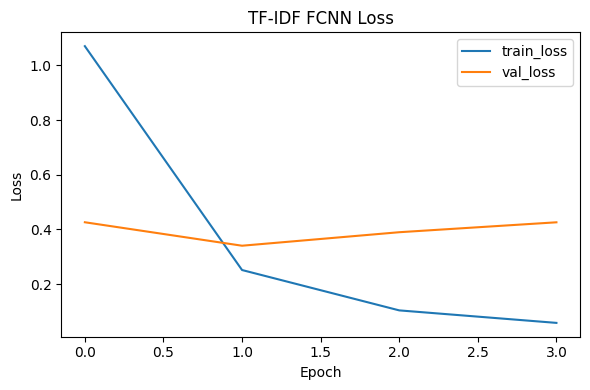

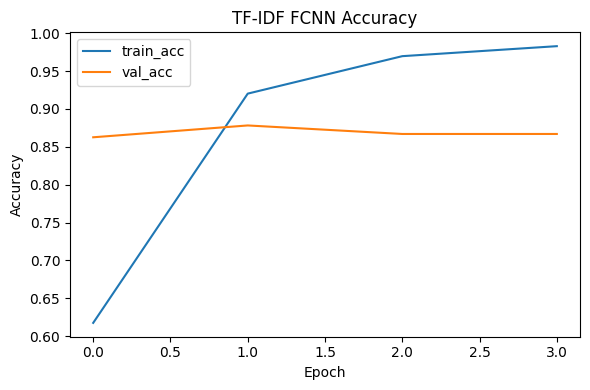

In [56]:
plt.figure(figsize=(6, 4))
plt.plot(tfidf_history.history["loss"], label="train_loss")
plt.plot(tfidf_history.history["val_loss"], label="val_loss")
plt.title("TF-IDF FCNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(tfidf_history.history["accuracy"], label="train_acc")
plt.plot(tfidf_history.history["val_accuracy"], label="val_acc")
plt.title("TF-IDF FCNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

**TF-IDF training curves (interpretation)**
- Training loss decreases steadily, while validation loss levels off, indicating mild overfitting after the first few epochs.
- Validation accuracy improves early and then plateaus, so the best checkpoint is usually near the first few epochs.
- Early stopping helps keep the model near its best generalization point.

In [57]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

tfidf_probs = tfidf_model.predict(X_test_tfidf_dense)
tfidf_pred = tfidf_probs.argmax(axis=1)

tfidf_accuracy = accuracy_score(y_test, tfidf_pred)
tfidf_precision, tfidf_recall, tfidf_f1, _ = precision_recall_fscore_support(
    y_test, tfidf_pred, average="macro", zero_division=0
)

print(f"TF-IDF Accuracy: {tfidf_accuracy:.4f}")
print(f"TF-IDF Precision (macro): {tfidf_precision:.4f}")
print(f"TF-IDF Recall (macro): {tfidf_recall:.4f}")
print(f"TF-IDF F1 (macro): {tfidf_f1:.4f}")

print("\nTF-IDF Classification report:\n")
print(classification_report(y_test, tfidf_pred, target_names=class_names, zero_division=0))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
TF-IDF Accuracy: 0.8740
TF-IDF Precision (macro): 0.8281
TF-IDF Recall (macro): 0.8264
TF-IDF F1 (macro): 0.8266

TF-IDF Classification report:

              precision    recall  f1-score   support

       anger       0.84      0.91      0.87       275
        fear       0.88      0.81      0.84       224
         joy       0.90      0.91      0.90       695
        love       0.74      0.77      0.75       159
     sadness       0.93      0.89      0.91       581
    surprise       0.70      0.67      0.68        66

    accuracy                           0.87      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.88      0.87      0.87      2000



In [58]:
from datetime import datetime

tfidf_row = {
    "model": "FC_TFIDF",
    "accuracy": round(tfidf_accuracy, 4),
    "precision": round(tfidf_precision, 4),
    "recall": round(tfidf_recall, 4),
    "f1": round(tfidf_f1, 4),
    "timestamp": datetime.now().isoformat(timespec="seconds"),
}

tfidf_metrics_df = pd.DataFrame([tfidf_row])

if metrics_path.exists():
    tfidf_metrics_df.to_csv(metrics_path, mode="a", header=False, index=False)
else:
    tfidf_metrics_df.to_csv(metrics_path, index=False)

print(f"Saved TF-IDF metrics to: {metrics_path}")
tfidf_metrics_df

Saved TF-IDF metrics to: ../results/metrics.csv


,model,accuracy,precision,recall,f1,timestamp
0,FC_TFIDF,0.874,0.8281,0.8264,0.8266,2026-02-07T14:00:06


## Summary

In this notebook, we trained FCNN baselines with Bag-of-Words and TF-IDF features using the same preprocessing. We experimented with regularization (extra layers, dropout, L2) to control overfitting. For TF-IDF, heavier regularization hurt performance, so we reverted to a simpler architecture. The final models use stable settings and provide solid baseline metrics for later comparison.

## Metrics Insights

- BoW achieves slightly stronger macro F1 than TF-IDF, which suggests better balance across classes on this dataset.
- Both models perform well on frequent classes (joy, sadness) while rare classes (surprise, love) remain harder.
- The gap between accuracy and macro F1 indicates class imbalance, so macro F1 is the more reliable comparison metric.